In [1]:
from __future__ import print_function, division
import json 
import numpy as np
import cv2
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import time
import os
import copy
import sys

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
DATASET_PATH = './Datasets/'

DATASET_DIR = 'v2_cam1_cam2_ split_by_driver/Camera 1/'

MODEL_NAME = 'Resnet50_all'

In [3]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

# 데이터 가져오기

In [6]:
classes ={
    "c0": "Drive Safe",
    "c1": "Text Right",
    "c2": "Talk Right",
    "c3": "Text Left",
    "c4": "Talk Left",
    "c5": "Adjust Radio",
    "c6": "Drink",
    "c7": "Reach Behind",
    "c8": "Hair & Makeup",
    "c9": "Talk Passenger"
}

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [9]:
image_datasets = {x: ImageFolder(os.path.join(DATASET_PATH + DATASET_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

datasets = train_val_dataset(image_datasets['train'])
datasets['test'] = image_datasets['test']

In [15]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

## 데이터 확인하기

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

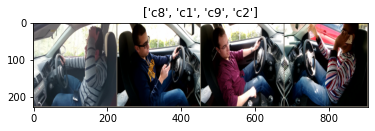

In [17]:
# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 모델 학습하기

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for index, (inputs, labels) in enumerate(dataloaders[phase]):
                printProgressBar (index, len(dataloaders[phase]), prefix='Progress', suffix='Complete', length=50)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            printProgressBar (len(dataloaders[phase]), len(dataloaders[phase]), prefix='Progress', suffix='Complete', length=50)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
def test_model(model):
    since = time.time()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, labels) in enumerate(dataloaders['test']):
            printProgressBar (index, len(dataloaders['test']), prefix='Progress', suffix='Complete', length=50)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            
            total += labels.size(0)
            correct += torch.sum(preds == labels.data)
            
    printProgressBar (len(dataloaders['test']), len(dataloaders['test']), prefix='Progress', suffix='Complete', length=50)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(correct.double() / dataset_sizes['test']))

# Resnet50

In [21]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model = train_model(model, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Progress |██████████████████████████████████████████████████| 100.0% Complete
train Loss: 0.1053 Acc: 0.9725
Progress |██████████████████████████████████████████████████| 100.0% Complete
val Loss: 0.0972 Acc: 0.9795

Epoch 1/9
----------
Progress |██████████████████████████████████████████████████| 100.0% Complete
train Loss: 0.0975 Acc: 0.9725
Progress |██████████████████████████████████████████████████| 100.0% Complete
val Loss: 0.0556 Acc: 0.9864

Epoch 2/9
----------
Progress |██████████████████████████████████████████████████| 100.0% Complete
train Loss: 0.0522 Acc: 0.9874
Progress |██████████████████████████████████████████████████| 100.0% Complete
val Loss: 0.0541 Acc: 0.9886

Epoch 3/9
----------
Progress |██████████████████████████████████████████████████| 100.0% Complete
train Loss: 0.0381 Acc: 0.9904
Progress |██████████████████████████████████████████████████| 100.0% Complete
val Loss: 0.0482 Acc: 0.9901

Epoch 4/9
----------
Progress |█████████████████

In [24]:
test_model(model)

Progress |██████████████████████████████████████████████████| 100.0% Complete
Training complete in 0m 11s
Test Acc: 0.813891
